In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline 
import numpy as np
import math
import pims
import cv2
from scipy import interpolate
from scipy.signal import savgol_filter
import skimage.filters as sk_fil
import imutils
from skimage.transform import rotate
import sys
import re
import pandas as pd
import PIL
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')
import myAnalyses.lowmag_analysis_OSS as dio

In [32]:

#path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/04-08-2022/Partitioned/Timelapse3/Filament3/'
path_movie = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Data/'
path_data = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Results_FINAL_FINAL_agar/Results_buckling_FINAL/'
path_out = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/'

#base = '23-12-06_2_FilamentE_450_1555'
#base = 'buckling'
#base_movie = 'buckling_raw_outsideClean/'
base_movie = 'buckling_raw/'
base_data = 'buckling_agar_x4_10sec_data'
base_out = 'Fig4_' + base_data
path_to_image_stack = path_movie + base_movie + r'*.tif'

saveFile_Fig4 = path_out+base_out+'.png'
saveFile1_Fig4 = path_out+base_out+'.tif'

#pick key parameters from file header
fline=open(path_data + base_data +".csv").readline().rstrip()
dum = [float(s) for s in re.findall(r'[\d]*[.][\d]+',fline)]
dt = dum[1]             #time interval of the movie
um_per_px = dum[0]      #um per pixel

df = pd.read_csv(path_data + base_data +".csv",skiprows=1,sep='\t')
df_values = df.iloc[:, 1:]
df_ids = df.iloc[:, 1]
filDat = df_values.to_numpy()

endA_x = filDat[:,1]*um_per_px
endA_y = filDat[:,2]*um_per_px
endB_x = filDat[:,3]*um_per_px
endB_y = filDat[:,4]*um_per_px
centre_x = filDat[:,5]*um_per_px
centre_y = filDat[:,6]*um_per_px
filLength = np.nanmedian(filDat[:,7])
trackLength = np.nanmedian(filDat[:,8])
trackEndA_x = np.nanmedian(filDat[:,9])*um_per_px
trackEndA_y = np.nanmedian(filDat[:,10])*um_per_px
trackEndB_x = np.nanmedian(filDat[:,11])*um_per_px
trackEndB_y = np.nanmedian(filDat[:,12])*um_per_px

dt, um_per_px


(10.0, 1.61)

In [11]:
###########
#position and speed analysis
###########

#key PARAMETERS to set
spline_k = 3                    #what order should we use when fitting the spling
spacing = 1                     #spacing to use for the gradient function used for speed calc
speedLimit = 0.035               #what speed limit we should use to decide "dwell" (i.e. reversal)
sparsity = 5
sparsityA = 9
sparsityB = 12
    
frame_ids = np.arange(0, len(endA_x),1)           #create a x-axis array based on frames 
frame_ids_sparse = np.arange(0, len(endA_x),sparsity)      #create a sparse x-axis
if frame_ids_sparse[-1] != len(endA_x)-1: frame_ids_sparse = np.append(frame_ids_sparse,len(endA_x)-1)  #make sure last frame id is included in the sparse set

#remove indices with nan values from sparse used for centre spline
nanIndices = np.where(np.isnan(centre_x[frame_ids_sparse])) #find any nan values in the position data, the frame id for which is included in the sparse set
frame_ids_sparse_C = np.delete(frame_ids_sparse,nanIndices)           #get rid of those frame ids from sparse set.

#remove indices with nan values from sparse used for endA spline
frame_ids_sparseA = np.arange(0, len(endA_x),sparsityA)      #create a sparse x-axis
if frame_ids_sparseA[-1] != len(endA_x)-1: frame_ids_sparseA = np.append(frame_ids_sparseA,len(endA_x)-1)  #make sure last frame id is included in the sparse set
nanIndices = np.where(np.isnan(endA_x[frame_ids_sparseA])) #find any nan values in the position data, the frame id for which is included in the sparse set
frame_ids_sparse_A = np.delete(frame_ids_sparseA,nanIndices)           #get rid of those frame ids from sparse set.

#remove indices with nan values from sparse used for endB spline
frame_ids_sparseB = np.arange(0, len(endA_x),sparsityB)      #create a sparse x-axis
if frame_ids_sparseB[-1] != len(endA_x)-1: frame_ids_sparseB = np.append(frame_ids_sparseB,len(endA_x)-1)  #make sure last frame id is included in the sparse set
nanIndices = np.where(np.isnan(endB_x[frame_ids_sparseB])) #find any nan values in the position data, the frame id for which is included in the sparse set
frame_ids_sparse_B = np.delete(frame_ids_sparseB,nanIndices)           #get rid of those frame ids from sparse set.

#dist to track ends
distC = np.zeros(len(centre_x))
distA = np.zeros(len(centre_x))
distB = np.zeros(len(centre_x))
for i in range(0,len(centre_x)):
    distC[i] = um_per_px*(np.sqrt((centre_x[i]-trackEndB_x)**2 + (centre_y[i]-trackEndB_y)**2)-filLength/2)
    distA[i] = um_per_px*np.sqrt((endA_x[i]-trackEndB_x)**2 + (endA_y[i]-trackEndB_y)**2)
    distB[i] = um_per_px*np.sqrt((endB_x[i]-trackEndA_x)**2 + (endB_y[i]-trackEndA_y)**2)

#spline fitting
splineC_dist = interpolate.splrep(frame_ids_sparse_C,distC[frame_ids_sparse_C],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
centre_dist_fitted = interpolate.splev(frame_ids, splineC_dist) #use spline to get smoothed curve at all frames for dist

splineA_dist = interpolate.splrep(frame_ids_sparse_A,distA[frame_ids_sparse_A],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
endA_dist_fitted = interpolate.splev(frame_ids, splineA_dist) #use spline to get smoothed curve at all frames for dist

splineB_dist = interpolate.splrep(frame_ids_sparse_B,distB[frame_ids_sparse_B],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
endB_dist_fitted = interpolate.splev(frame_ids, splineB_dist) #use spline to get smoothed curve at all frames for dist

splineC_x = interpolate.splrep(frame_ids_sparse_C,centre_x[frame_ids_sparse_C],s=0, k=spline_k) #spline fit centre_x coordinates using data points from frames in the sparse set
centre_x_fitted = interpolate.splev(frame_ids, splineC_x) #use spline to get smoothed curve at all frames for centre_x

splineC_y = interpolate.splrep(frame_ids_sparse_C,centre_y[frame_ids_sparse_C],s=0, k=spline_k) #spline fit centre_y coordinates using data points from frames in the sparse set
centre_y_fitted = interpolate.splev(frame_ids, splineC_y) #use spline to get smoothed curve at all frames for centre_y

splineA_x = interpolate.splrep(frame_ids_sparse_A,endA_x[frame_ids_sparse_A], s=0, k=spline_k) #spline fit endA_x coordinates using data points from frames in the sparse set
endA_x_fitted = interpolate.splev(frame_ids, splineA_x) #use spline to get smoothed curve at all frames for endA_x

splineA_y = interpolate.splrep(frame_ids_sparse_A,endA_y[frame_ids_sparse_A], s=0, k=spline_k) #spline fit endA_x coordinates using data points from frames in the sparse set
endA_y_fitted = interpolate.splev(frame_ids, splineA_y) #use spline to get smoothed curve at all frames for endA_x

splineB_x = interpolate.splrep(frame_ids_sparse_B,endB_x[frame_ids_sparse_B], s=0, k=spline_k) #spline fit endA_x coordinates using data points from frames in the sparse set
endB_x_fitted = interpolate.splev(frame_ids, splineB_x) #use spline to get smoothed curve at all frames for endA_x
endB_x_fitted_der = interpolate.splev(frame_ids, splineB_x, der=1) #use spline to get smoothed curve at all frames for endA_x

splineB_y = interpolate.splrep(frame_ids_sparse_B,endB_y[frame_ids_sparse_B], s=0, k=spline_k) #spline fit endA_x coordinates using data points from frames in the sparse set
endB_y_fitted = interpolate.splev(frame_ids, splineB_y) #use spline to get smoothed curve at all frames for endA_x
endB_y_fitted_der = interpolate.splev(frame_ids, splineB_y, der=1) #use spline to get smoothed curve at all frames for endA_x


#speed from fitted x- and y-coordinates
speedC_x1 = interpolate.splev(frame_ids, splineC_x,der=1)/dt
speedC_y1 = interpolate.splev(frame_ids, splineC_y,der=1)/dt
speedC_xy1 = np.sqrt(speedC_x1**2 + speedC_y1**2)
speedC_x = np.gradient(centre_x_fitted,spacing)/dt
speedC_y = np.gradient(centre_y_fitted,spacing)/dt
speedC_xy = np.sqrt(speedC_x**2 + speedC_y**2)

speedA_x = np.gradient(endA_x_fitted,spacing)/dt
speedA_y = np.gradient(endA_y_fitted,spacing)/dt
speedA_xy = np.sqrt(speedA_x**2 + speedA_y**2)

#speedB_x = np.gradient(endB_x_fitted,edge_order=2)/dt
speedB_x = np.gradient(endB_x_fitted,spacing)/dt
speedB_y = np.gradient(endB_y_fitted,spacing)/dt
speedB_xy = np.sqrt(speedB_x**2 + speedB_y**2)
speedB_xy2 = np.sqrt((endB_x_fitted_der/dt)**2 + (endB_y_fitted_der/dt)**2)



###########
#analyse dwell time
###########


stopRegionsA = frame_ids[np.where(np.abs(speedA_xy)<speedLimit)]
nReversalsA = 0
if len(stopRegionsA)>0:
    stopIntervalsA=list(dio.group(stopRegionsA))
    nReversalsA = len(stopIntervalsA)

stopRegionsB = frame_ids[np.where(np.abs(speedB_xy)<speedLimit)]
nReversalsB = 0
if len(stopRegionsB)>0:
    stopIntervalsB=list(dio.group(stopRegionsB))
    nReversalsB = len(stopIntervalsB)


In [37]:
###########
#LOAD TIMELAPSE, CHECK TYPE, NORMALISE INTENSITY
###########

#open image stack
frames = pims.open(path_to_image_stack)

#convert image datatype, first to float to normalise and then to uint8
#first get max pixel value
k=0
maxPixel=0
for frame in frames:
    intPixel = max(frame.flat)
    if intPixel>maxPixel:
        maxPixel=intPixel
        frameID = k
    k=k+1

#maxPixelValue = np.iinfo(frames[120].dtype).max             #get max allowed pixel value
frames1 = pims.pipeline(lambda x: x.astype(np.float32))(frames) #convert to float32 first
frames2 = pims.pipeline(lambda x: x*(255/maxPixel))(frames1) #normalize to 0-255 range
frames3 = pims.pipeline(lambda x: x.astype(np.uint8))(frames2)  #convert to uint8 
frames = frames3
len(frames)

150

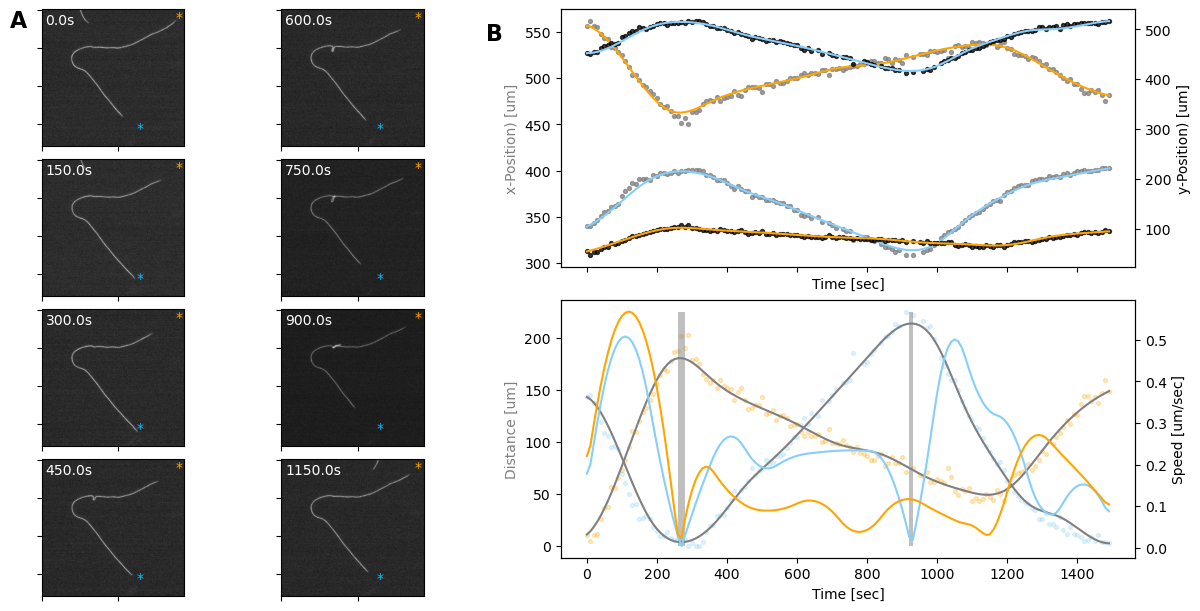

In [46]:
#FANCY PLOT
#OK - let's plot a fancy plot!

fig = plt.figure(layout='constrained', figsize=(12, 6))
#fig = plt.figure(layout='tight', figsize=(12, 6))
#plt.subplots_adjust(left = 0.05, right= 0.95, bottom=0.01, top=0.99,wspace=0.05, hspace=0.05)
#fig = plt.figure(figsize=(12, 6))
#left  = 0.125  # the left side of the subplots of the figure
#right = 0.9    # the right side of the subplots of the figure
#bottom = 0.1   # the bottom of the subplots of the figure
#top = 0.9      # the top of the subplots of the figure
#wspace = 0.2   # the amount of width reserved for blank space between subplots
#hspace = 0.2   # the amount of height reserved for white space between subplots
subfigs = fig.subfigures(1, 2,width_ratios=[2/5,3/5])

#A - PLOT MOVIE STILLS
axsLeft = subfigs[0].subplots(4, 2, sharex=True,sharey=True)
#figA.subplots_adjust(left = 0.05, right= 0.95, bottom=0.01, top=0.99,wspace=0.02, hspace=0.02)
axsLeft[0,0].text(-0.1, 1, 'A', transform=axsLeft[0,0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
tPoints = [0,60,15,75,30,90,45,115]
k = 0
for i in range(0,4):
      for j in range(0,2):
          axsLeft[i,j].imshow(frames[tPoints[k]],cmap='gray')
          axsLeft[i,j].annotate('*',xy=(trackEndB_x/um_per_px,trackEndB_y/um_per_px),color='deepskyblue')
          axsLeft[i,j].annotate('*',xy=(trackEndA_x/um_per_px,trackEndA_y/um_per_px),color='orange')
          axsLeft[i,j].annotate(str(tPoints[k]*dt)+'s',xy=(10,40),color='white')
          plt.setp(axsLeft[i,j].get_xticklabels(), visible=False)
          plt.setp(axsLeft[i,j].get_yticklabels(), visible=False)
          k=k+1
          

#B - PLOT POSITION, SPEED, ETC.
axsRight = subfigs[1].subplots(2, 1,sharex=True)
axsRight[0].text(-0.1, 0.95, 'B', transform=axsRight[0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')
axsRight[0].plot(frame_ids*dt,endA_x_fitted,color='lightskyblue')  #spline for endA x-pos
axsRight[0].scatter(frame_ids*dt, endA_x,marker='o',s=8,color='gray',alpha=0.75)  #actual endA x-pos
axsRight[0].plot(frame_ids*dt,endB_x_fitted,color='orange')  #spline for endB x-pos
axsRight[0].scatter(frame_ids*dt, endB_x,marker='o',s=8,color='gray',alpha=0.75)  #actual endB x-pos
axsRight[0].set_ylabel('x-Position) [um]',color='gray')
axsRight[0].set_xlabel('Time [sec]')
ax2_2 = axsRight[0].twinx() 
ax2_2.plot(frame_ids*dt,endA_y_fitted,color='lightskyblue')  #spline for endB x-pos
ax2_2.scatter(frame_ids*dt, endA_y,marker='o',s=8,color='k',alpha=0.75)  #actual endB x-pos
ax2_2.plot(frame_ids*dt,endB_y_fitted,color='orange')  #spline for endB y-pos
ax2_2.scatter(frame_ids*dt, endB_y,marker='o',s=8,color='k',alpha=0.75)  #actual endB y-pos
ax2_2.set_ylabel('y-Position) [um]',color="k")

axsRight[1].plot(frame_ids*dt,endA_dist_fitted,color='gray',label="endA")  #spline for endA dist to track end
axsRight[1].scatter(frame_ids*dt, distA,marker='o',s=8,color='lightskyblue', alpha=0.25)  #actual endA dist to track end
axsRight[1].plot(frame_ids*dt,endB_dist_fitted,color='gray',label="endB")  #spline for endB dist to track end
axsRight[1].scatter(frame_ids*dt, distB,marker='o',s=8,color='orange', alpha=0.25)  #actual endB dist to track end
axsRight[1].set_ylabel('Distance [um]',color='gray')
axsRight[1].set_xlabel('Time [sec]')
ax3_2 = axsRight[1].twinx() 
ax3_2.plot(frame_ids*dt,np.abs(speedA_xy),color='lightskyblue')  #spline to endA speed
ax3_2.plot(frame_ids*dt,np.abs(speedB_xy),color='orange')  #spline to endB speed
#ax3_2.plot(frame_ids,np.abs(speedB_xy2),color='orange',marker='o')  #spline to endB speed with derivative approach - to check equivalence to gradient approach
ax3_2.set_ylabel('Speed [um/sec]')

for i in range(0,nReversalsA):
      start = stopIntervalsA[i][0]
      end = stopIntervalsA[i][1]
      width = (end - start)*dt
      if width==0: width=1
      rect = patches.Rectangle((frame_ids[start]*dt,0), width,max(distA), fill=True, alpha=0.5,linewidth=1, edgecolor='none', facecolor='gray')
      axsRight[1].add_patch(rect)

fig.savefig(saveFile_Fig4)
fig.savefig(saveFile1_Fig4)
#plt.xscale('log')
plt.show()
plt.close(fig)
 